In [ ]:
!pip install yfinance


**Import Dataset Saham Google kelas C**

In [ ]:
import yfinance as yf

# Mengunduh data harga saham google kelas C (GOOG) dari Yahoo Finance
data = yf.download('GOOG', start='2022-01-01', end='2024-12-31')
data.to_csv('GOOG.csv')


[*********************100%***********************]  1 of 1 completed


**LSTM Method**

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0281
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch

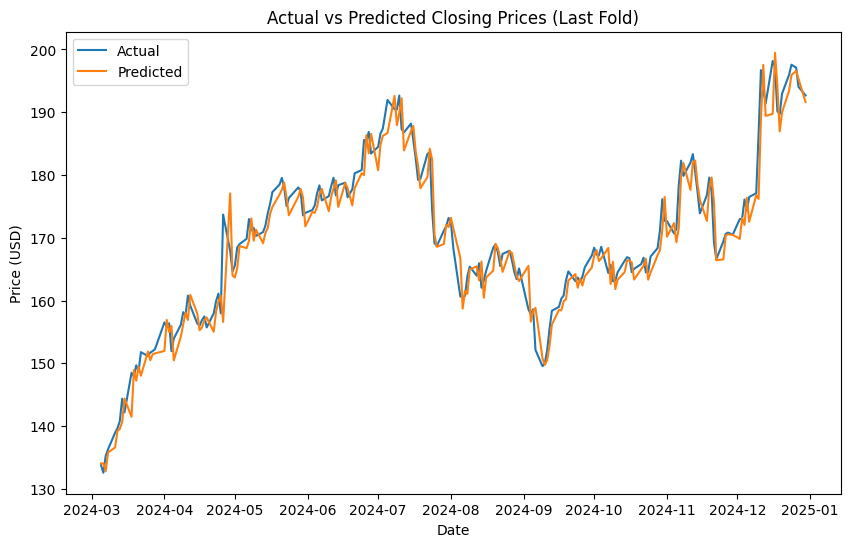

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# Load dataset
data = pd.read_csv('GOOG.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Prepare data
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)

# Create sequences
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

sequence_length = 60
x, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing datasets
train_size = int(len(x) * 0.7)
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=32, epochs=100)

# Predict and evaluate
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, predictions)

# Display results
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'R^2: {r2}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test_actual, label='Actual')
plt.plot(data.index[-len(y_test):], predictions, label='Predicted')
plt.title('Actual vs Predicted Close')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


**Random Forest Method**

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}
Average RMSE: 9.336037940553442
Average MAE: 7.36550074333436
Average MAPE: 5.454588818810586
Average R^2: 0.1367902284021876


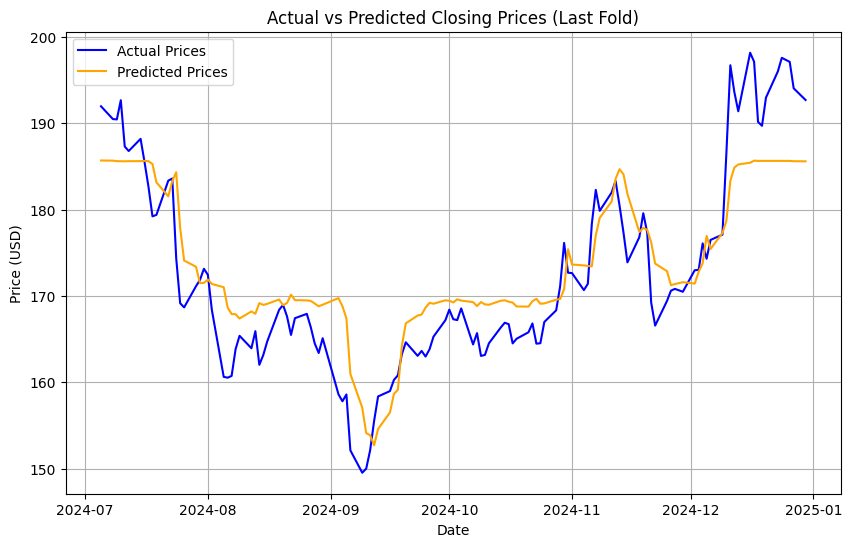

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('GOOG.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.sort_index()

# Feature Engineering: Create lag features and moving averages
lags = 5
for i in range(1, lags + 1):
    data[f'lag_{i}'] = data['Close'].shift(i)
data['rolling_mean_5'] = data['Close'].rolling(window=5).mean()
data['rolling_std_5'] = data['Close'].rolling(window=5).std()
data = data.dropna()

# Define features and target
X = data[[f'lag_{i}' for i in range(1, lags + 1)] + ['rolling_mean_5', 'rolling_std_5']]
y = data['Close']

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize Random Forest
rf = RandomForestRegressor(random_state=42)

# Hyperparameter tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV on the training data
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    break  # Perform tuning only on the first fold

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Evaluate on all folds
rmse_list, mae_list, mape_list, r2_list = [], [], [], []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

# Final metrics
print("Average RMSE:", np.mean(rmse_list))
print("Average MAE:", np.mean(mae_list))
print("Average MAPE:", np.mean(mape_list))
print("Average R^2:", np.mean(r2_list))

# Visualize last fold results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Prices', color='orange')
plt.title('Actual vs Predicted Closing Prices (Last Fold)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()
